# Predicting Most Profitable Altcoin Based on Bitcoin and Crypto Market Data

In this analysis we use crypto market data, google trends, some stock market data like gold price and dollar index and market sentiment to predict which altcoin (between Bonk, Hamster Kombat Coin, Ripple, ADA, and Floki Ino) will have the highest return in a 12 hours interval.

In [1]:
import requests
import time
import pandas as pd
import numpy as np
import requests
import datetime
import time
import urllib.parse
import warnings

from pytrends.request import TrendReq

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

import random, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import shap

warnings.filterwarnings('ignore')

## Fetching Data

### Altcoins:

we use binance to download crypto historical data

In [2]:
def get_klines(symbol, interval, start_time, end_time=None):
    url = 'https://api.binance.com/api/v3/klines'
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': 1000
    }
    if end_time:
        params['endTime'] = end_time
    response = requests.get(url, params=params)
    return response.json()

def create_df(symbol):
    '''Creates a data frame of all available daily data for the given symbol'''
    interval = '12h'
    start_time = int(time.mktime(time.strptime('2021-01-01', '%Y-%m-%d')) * 1000)
    all_data = []

    while True:
        klines = get_klines(symbol, interval, start_time)
        if not klines:
            break
        all_data.extend(klines)
        # Move start_time to the next candle
        start_time = klines[-1][0] + 86400000  # Add 1 day in ms
        time.sleep(0.5)  # Avoid rate limits

    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=[
        "datetime", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base_volume", "taker_buy_quote_volume", "ignore"
    ])
    
    df["datetime"] = pd.to_datetime(df["datetime"], unit="ms")
    df = df[["datetime", "open", "high", "low", "close", "volume"]]
    df.to_csv(f"{symbol}.csv")

    return df

In [ ]:
btc = create_df("BTCUSDT")
bonk = create_df("BONKUSDT")
hmstr = create_df("HMSTRUSDT")
xrp = create_df("XRPUSDT")
ada = create_df("ADAUSDT")
floki = create_df("FLOKIUSDT")

### Sentiment:

we use alternative.me to fetch market historical sentiment

In [ ]:
url = "https://api.alternative.me/fng/?limit=1667&format=json"
response = requests.get(url)
data = response.json()['data']

df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['value'] = df['value'].astype(int)
df.rename(columns={'timestamp':'datetime', 'value': 'Sentiment'}, inplace=True)

sentiment = df.set_index('datetime')['Sentiment']
sentiment.sort_index(inplace=True)
sentiment = sentiment.resample('12H').ffill()
sentiment.to_csv('sentiment.csv')

### Google Trends:

we use pytrends to download interests over time for each crypto

In [ ]:
pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ['floki', 'bonk', 'hamster kombat coin']
kw_list2 = ['XRP', 'ADA', 'bitcoin']

pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')
trends = pytrends.interest_over_time().drop(columns='isPartial')

pytrends.build_payload(kw_list2, cat=0, timeframe='today 5-y', geo='', gprop='')
trends2 = pytrends.interest_over_time().drop(columns='isPartial')

In [ ]:
trends.index.name = 'datetime'
trends2.index.name = 'datetime'

trends.sort_index(inplace=True)
trends = trends.resample('12H').ffill()

trends2.sort_index(inplace=True)
trends2 = trends2.resample('12H').ffill()

trends2.merge(trends, left_index=True, right_index=True).to_csv('google_trends.csv')

### Dollar and Gold:

we use yahoo finance to get gold price and dollar index

In [7]:
symbols = {
    "gold": "GC=F",
    "dxy": "DX-Y.NYB"
}

start = int(time.mktime(datetime.datetime(2021, 1, 5, 12, 0).timetuple()))
end = int(time.time())

def fetch_historical_data(symbol, interval="1d"):
    symbol_encoded = urllib.parse.quote(symbol, safe='')
    url = f"https://query1.finance.yahoo.com/v8/finance/chart/{symbol_encoded}"
    params = {
        "period1": start,
        "period2": end,
        "interval": interval,
        "includePrePost": "false",
        "events": "history"
    }
    headers = {"User-Agent": "Mozilla/5.0"}

    r = requests.get(url, params=params, headers=headers)
    if r.status_code != 200:
        raise ValueError(f"HTTP Error {r.status_code}")

    try:
        data = r.json()
    except Exception as e:
        print("Response content:", r.text[:200])  # peek first 200 chars
        raise

    try:
        timestamps = data['chart']['result'][0]['timestamp']
        quotes = data['chart']['result'][0]['indicators']['quote'][0]
        return pd.DataFrame([
            {
                "datetime": datetime.datetime.fromtimestamp(ts),
                "open": quotes["open"][i],
                "high": quotes["high"][i],
                "low": quotes["low"][i],
                "close": quotes["close"][i],
                "volume": quotes.get("volume", [None])[i],
            }
            for i, ts in enumerate(timestamps)
        ])
    except Exception as e:
        raise ValueError(f"Data format error: {e}")

In [ ]:
gold_data = fetch_historical_data(symbols["gold"])
dxy_data = fetch_historical_data(symbols["dxy"])

In [ ]:
for df in [gold_data, dxy_data]:
    df.set_index('datetime', inplace=True)
    df.sort_index(inplace=True)
    df2 = df.resample('12H').ffill()
    df.drop(df.index, inplace=True)  
    df[df2.columns] = df2
    df.index = df2.index  

In [ ]:
gold_data.to_csv('gold.csv')
dxy_data.to_csv('dxy.csv')

## Loading data and creating dataframe

reading datasets

In [11]:
btc = pd.read_csv("BTCUSDT.csv")
bonk = pd.read_csv("BONKUSDT.csv")
hmstr = pd.read_csv("HMSTRUSDT.csv")
xrp = pd.read_csv("XRPUSDT.csv")
ada = pd.read_csv("ADAUSDT.csv")
floki = pd.read_csv("FLOKIUSDT.csv")
sentiment = pd.read_csv("sentiment.csv")
gold = pd.read_csv('gold.csv')
dxy = pd.read_csv('dxy.csv')
trends = pd.read_csv('google_trends.csv')

converting to datetime and setting datetime as index

In [12]:
dfs = [btc, bonk, hmstr, xrp, ada, floki, sentiment, gold, dxy, trends]

for df in dfs:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    try:
        df['percent_change'] = ((df['close'] - df['open']) / df['open']) * 100 # we add percent changed to cypto datasets

    except KeyError:
        pass

creating the main dataframe

In [13]:
df = pd.DataFrame({'PercentChanged':btc['percent_change'], 
                   'ClosePrice': btc['close'],
                   'Volume': btc['volume'],
                   'Gold': gold['percent_change'],
                   'Dxy': dxy['percent_change'],
                   'BTC_trends': trends['bitcoin'],
                   'Floki_trends': trends['floki'],
                   'Bonk_trends': trends['bonk'],
                   'Hamster_trends': trends['hamster kombat coin'],
                   'Xrp_trends': trends['XRP'],
                   'Ada_trends': trends['ADA'],
                   'Sentiment': sentiment['Sentiment'],
                   'FLOKI':floki['percent_change'], 
                   'BONK':bonk['percent_change'], 
                   'HMSTR':hmstr['percent_change'], 
                   'XRP':xrp['percent_change'], 
                   'ADA':ada['percent_change']})

trimming the dataset to avoid null values for bitcoin and sentiment

In [14]:
df = df[~df['Sentiment'].isna()]
df = df[df.index<'2025-08-17 00:00:00']

final result

In [15]:
df

,PercentChanged,ClosePrice,Volume,Gold,Dxy,BTC_trends,Floki_trends,Bonk_trends,Hamster_trends,Xrp_trends,Ada_trends,Sentiment,FLOKI,BONK,HMSTR,XRP,ADA
datetime,,,,,,,,,,,,,,,,,
2021-01-25 00:00:00,2.869888,33185.26,37059.579800,0.043125,NaN,49.0,14.0,9.0,0.0,3.0,22.0,74.0,NaN,NaN,NaN,0.526797,0.910994
2021-01-25 12:00:00,-2.805614,32254.20,51439.647121,-0.525550,0.177320,49.0,14.0,9.0,0.0,3.0,22.0,74.0,NaN,NaN,NaN,-2.648717,-3.812942
2021-01-26 00:00:00,-1.417614,31796.95,42546.690792,-0.525550,0.177320,49.0,14.0,9.0,0.0,3.0,22.0,71.0,NaN,NaN,NaN,-0.781279,-1.023801
2021-01-26 12:00:00,2.104240,32467.77,42425.516118,-0.274819,-0.243391,49.0,14.0,9.0,0.0,3.0,22.0,71.0,NaN,NaN,NaN,1.103952,1.169953
2021-01-27 00:00:00,-5.621487,30639.05,34593.290206,-0.274819,-0.243391,49.0,14.0,9.0,0.0,3.0,22.0,78.0,NaN,NaN,NaN,-6.073704,-6.851669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-14 12:00:00,-2.194773,118295.09,17287.325090,-0.346603,0.511509,41.0,17.0,47.0,1.0,19.0,25.0,75.0,-8.942241,-8.243451,-8.111534,-4.316211,-3.832970
2025-08-15 00:00:00,0.600972,119006.01,4746.287340,-0.346603,0.511509,41.0,17.0,47.0,1.0,19.0,25.0,60.0,0.726092,1.679966,1.657459,1.035983,1.804040
2025-08-15 12:00:00,-1.398215,117342.05,8877.051400,-0.322698,-0.336119,41.0,17.0,47.0,1.0,19.0,25.0,60.0,-1.100256,-2.395704,-0.543478,-1.067147,0.307725


each crypto has null values before being availbale on the market, we replace these values with zero because we don't want them to affect our labels

In [16]:
df[['FLOKI', 'BONK', 'HMSTR', 'XRP', 'ADA']] = df[['FLOKI', 'BONK', 'HMSTR', 'XRP', 'ADA']].fillna(0)

we create label using this rule: name of crypto with highest positive percent changed.

In [17]:
df['Label'] = df[['PercentChanged', 'FLOKI', 'BONK', 'HMSTR', 'XRP', 'ADA']].mask(df[['PercentChanged', 'FLOKI', 'BONK', 'HMSTR', 'XRP', 'ADA']] <= 0).idxmax(axis=1)

if all the crypto values where negative, then the best thing is to not invest in anything. we label these datapoints with "don't".

In [18]:
df['Label'].fillna('DONT', inplace=True)

also if bitcoin was the most profitable crypto, we should avoid investing in altcoins.

In [19]:
df['Label'] = df['Label'].apply(lambda x: 'DONT' if x=='PercentChanged' else x)

## EDA

### 1. Adding New Features:

we want to create a feature called Days Positive, which counts the number of consecutive days that Bitcoin closed with a positive return

In [20]:
non_pos = df['PercentChanged'] <= 0
groups = non_pos.cumsum()

pos_counts = df['PercentChanged'].gt(0).groupby(groups).cumsum() - 1
pos_counts = pos_counts.clip(lower=0)

df['DaysPositive'] = pos_counts

also we will add some financial features like Moving Averages and Relative Strength Index

In [21]:
# Simple Moving Average (SMA)
df['MA'] = df['ClosePrice'].rolling(window=10).mean()

# Exponential Moving Average (EMA)
df['EMA'] = df['ClosePrice'].ewm(span=10, adjust=False).mean()

# RSI (Relative Strength Index)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['ClosePrice'], period=14)

now we add hour, day of the week, day of month and a binary feature to determine if it's weekend

In [22]:
df['Hour'] = df.index.hour
df['WeekDay'] = df.index.day_of_week
df['MonthDay'] = df.index.day
df['IsWeekend'] = df['WeekDay'].apply(lambda x: 1 if x>4 else 0)

### 2. Transforming Features:

In [23]:
enc = LabelEncoder()
df['Label'] = enc.fit_transform(df['Label'])

    Important Consideration: we want to find the best buy for the upcoming 12 hours based on data from the last 12 hours, that's why we shift data by -1, except for temporal features.

In [24]:
no_shift = ['Label', 'Hour', 'WeekDay', 'MonthDay', 'IsWeekend']

df[[col for col in df.columns if col not in no_shift]] = df[[col for col in df.columns if col not in no_shift]].shift(-1)

### 3. Visualization:

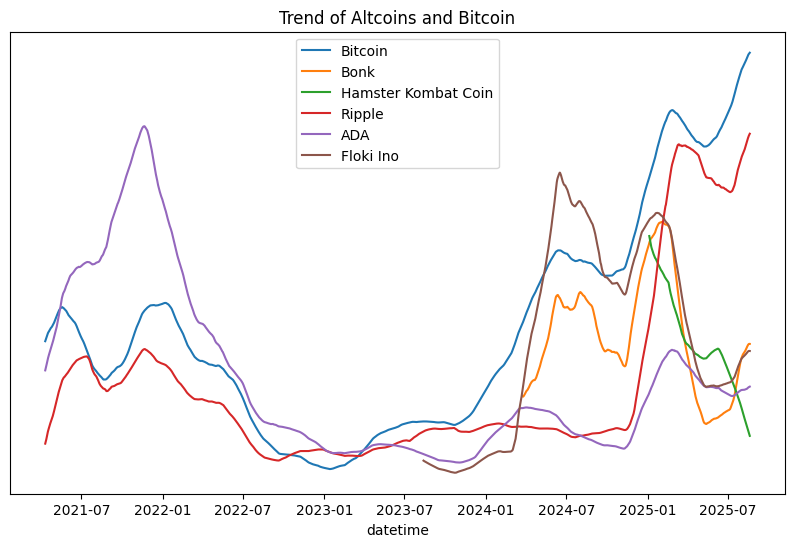

In [25]:
df_n_label = [(btc, 'Bitcoin'), (bonk, 'Bonk'), (hmstr, 'Hamster Kombat Coin'), (xrp, 'Ripple'), (ada, 'ADA'), (floki, 'Floki Ino')]

def plot():
    plt.figure(figsize=(10,6))
    plt.title('Trend of Altcoins and Bitcoin')
    plt.gca().axes.get_yaxis().set_visible(False)
    for df, label in df_n_label:
        series = (df['close']-df['close'].min())/(df['close'].max()-df['close'].min())
        smoothed = series.rolling(window=200).mean()
        sns.lineplot(smoothed, label=label)

        plt.legend()
plot()

we can see that the trends are very similar to each other, except with different magnitudes.

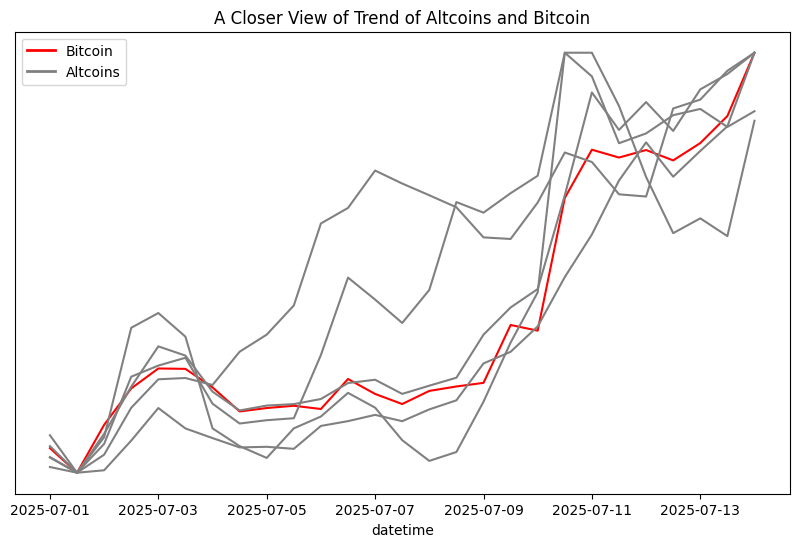

In [ ]:
def plot():
    plt.figure(figsize=(10,6))
    plt.title('A Closer View of Trend of Altcoins and Bitcoin')
    plt.gca().axes.get_yaxis().set_visible(False)
    for df, label in df_n_label:
        color = 'red' if label=='Bitcoin' else 'grey'
        df = df.loc['2025-07-01 00:00:00':'2025-07-14 00:00:00']
        series = (df['close']-df['close'].min())/(df['close'].max()-df['close'].min())
        sns.lineplot(series, color=color)
    
        custom_lines = [
        Line2D([0], [0], color="red", lw=2),
        Line2D([0], [0], color="grey", lw=2)
    ]

    plt.legend(custom_lines, ["Bitcoin", "Altcoins"])

plot()

we can see tiny lags between changes in bitcoin and altcoins.

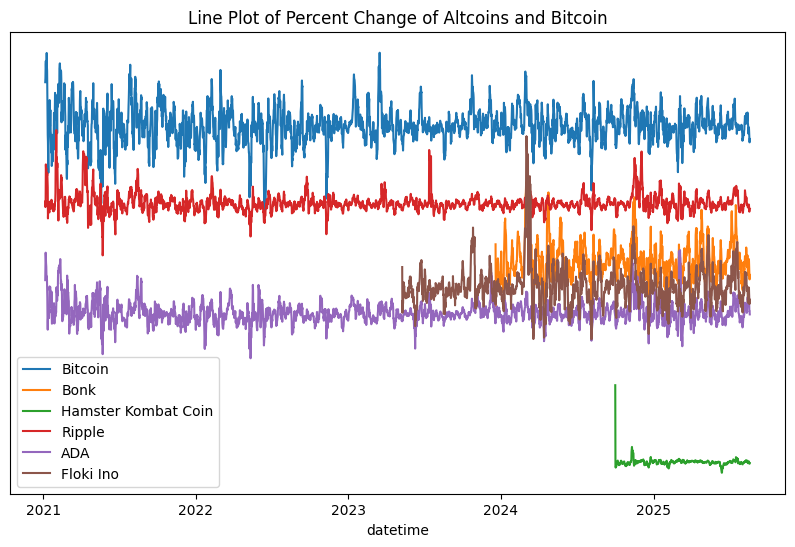

In [27]:
def plot():
    plt.figure(figsize=(10,6))
    plt.title('Line Plot of Percent Change of Altcoins and Bitcoin')
    plt.gca().axes.get_yaxis().set_visible(False)
    for df, label in df_n_label:
        series = (df['percent_change']-df['percent_change'].min())/(df['percent_change'].max()-df['percent_change'].min())
        smoothed = series.rolling(window=10).mean()
        sns.lineplot(smoothed, label=label)

        plt.legend()
plot()

like trends, percent changes of these crypto symbols are very similar, however we can see that in larger timeframes, bitcoin was more profitable while riskier altcoins were less profitable.

Text(0.5, 1.0, 'Plot of Data Points in 2D Using TSNE')

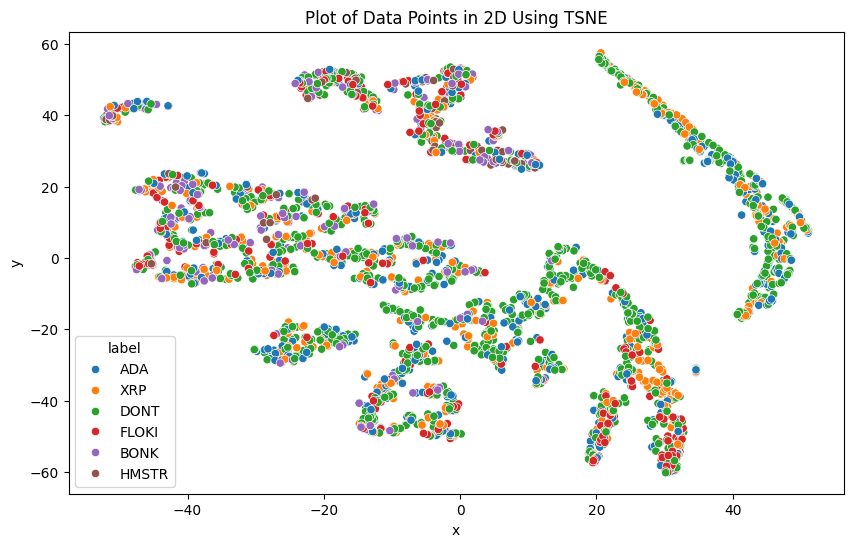

In [29]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df.drop(columns='Label').dropna().loc[:'2025-08-15 12:00:00',:])

df_tsne = pd.DataFrame(X_tsne, columns=["x", "y"])
df_tsne['label'] = enc.inverse_transform(df.dropna()['Label'].shift(-1).dropna().astype(int))

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_tsne,
    x="x", y="y",
    hue="label",
)
plt.title('Plot of Data Points in 2D Using TSNE')

while green datapoints (don't invest days) are distributed everywhere, some areas show specific behavior. for example bonk and floki do not apear on top right.

## Fitting the Model

In [30]:
def test_temporal(df, model, list_of_fits=[(SimpleImputer(strategy='mean'), False), (StandardScaler(), False)], train_end="2025-07-04 00:00:00", test_end="2025-07-16 12:00:00", fee=1):

    """This function splits df using train_end and test_end, fits functions given in list_of_fits on train and test, then fits the model on train and evaluates it on test by calculating accuracy
    and profit (assuming a fixed amount of investment in each trade and that sum of buy and sell fee is given in fee)"""

    df.index = pd.to_datetime(df.index)
    
    X_tr = df.loc[:train_end, :].drop(columns='Label')
    y_tr = df.loc[:train_end, 'Label']

    pos = df.index.get_loc(pd.to_datetime(train_end))
    next_idx = df.index[pos + 1]

    X_te = df.loc[next_idx:test_end, :].drop(columns='Label')
    y_te = df.loc[next_idx:test_end, 'Label']

    for fit, required_y in list_of_fits:

        if not required_y:
            X_tr = fit.fit_transform(X_tr)
            X_te = fit.transform(X_te)
        else:
            X_tr = fit.fit_transform(X_tr, y_tr)
            X_te = fit.transform(X_te)

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    labels = enc.inverse_transform(pred)
    profit = -fee
    
    freq = (next_idx-train_end).components[1]
    dates = pd.date_range(start=next_idx, end=test_end, freq=f"{freq}h")

    prev_label = ''
    
    for index, label in enumerate(labels):
        if label == 'DONT':
            continue

        if label != prev_label:
            profit -= fee

        profit += df.loc[dates[index], label]
        prev_label = label

    return accuracy_score(pred, y_te), profit

In [31]:
def test_16_times(df, model, list_of_fits=[(SimpleImputer(strategy='mean'), False), (StandardScaler(), False)]):

    """Uses test_temporal to fit and evaluate model on df 16 times. Each time we fit the model, we test on the next 14 days. Returns average results"""

    dates = pd.date_range(start='2025-01-04 00:00:00', end="2025-08-04 00:00:00", freq="14D")
    accs = []
    profs = []

    for i in range(len(dates)):
        if i<len(dates)-1:
            acc, profit = test_temporal(df, model, list_of_fits, train_end=dates[i], test_end=dates[i+1])
            accs.append(acc)
            profs.append(profit)
    
    return np.mean(accs), np.var(accs), np.mean(profs), np.min(profs), np.max(profs)

we start by testing different classifiers

In [32]:
def fit_models(df):

    names = [
        "Nearest Neighbors",
        "Logistic Regression",
        "RBF SVM",
        "Decision Tree",
        "Random Forest",
        "AdaBoost",
        "Naive Bayes",
        "QDA",
    ]

    classifiers = [
        KNeighborsClassifier(3),
        LogisticRegression(random_state=42),
        SVC(gamma=2, C=1, random_state=42),
        DecisionTreeClassifier(max_depth=5, random_state=42),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
        AdaBoostClassifier(random_state=42),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
    ]

    print('Results')
    print('Classifier ----- Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit')
    for id in range(len(classifiers)):
        model = classifiers[id]
        acc, var, prof, min, max = test_16_times(df, model)
        print(names[id], acc, var, prof, min, max)
        print('-'*90)

In [33]:
fit_models(df)

Results
Classifier ----- Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit
Nearest Neighbors 0.1809523809523809 0.003480725623582766 -16.53976897377207 -59.33792041657819 36.928425294973835
------------------------------------------------------------------------------------------
Logistic Regression 0.2142857142857143 0.0052721088435374154 -22.438957200991744 -90.77433930975317 9.412251010707024
------------------------------------------------------------------------------------------
RBF SVM 0.26190476190476186 0.013038548752834467 -1.0 -1 -1
------------------------------------------------------------------------------------------
Decision Tree 0.20952380952380953 0.007460317460317461 -12.898067023180259 -75.68302720136477 30.51926841956702
------------------------------------------------------------------------------------------
Random Forest 0.2642857142857143 0.012040816326530614 -3.7556205630222523 -22.45557708747578 3.4612702461565767
---------------

### 1. Decision Tree Classifier

In [34]:
acc, var, prof, min, max = test_16_times(df, DecisionTreeClassifier(max_depth=5, random_state=42), [(SimpleImputer(strategy='mean'), False), (StandardScaler(), False), (SelectKBest(k=15, score_func=f_classif), True)])
print('Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit')
print(round(acc, 4), round(var, 4), round(prof, 4), round(min, 4), round(max, 4), sep=' '*10)

Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit
0.2857          0.0104          14.668          -8.5119          48.5314


### 2. Logistic Regression

In [35]:
acc, var, prof, min, max = test_16_times(df, LogisticRegression(random_state=42), [(SimpleImputer(strategy='mean'), False), (StandardScaler(), False), (SelectKBest(k=14, score_func=f_classif), True)])
print('Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit')
print(round(acc, 4), round(var, 4), round(prof, 4), round(min, 4), round(max, 4), sep=' '*10)

Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit
0.2405          0.0064          8.3686          -32.9748          75.4573


### 3. SVC

In [36]:
acc, var, prof, min, max = test_16_times(df, SVC(gamma=0.1, C=0.7, random_state=42), [(SimpleImputer(strategy='mean'), False), (StandardScaler(), False), (SelectKBest(k=14, score_func=f_classif), True)])
print('Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit')
print(round(acc, 4), round(var, 4), round(prof, 4), round(min, 4), round(max, 4), sep=' '*10)

Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit
0.2571          0.0106          2.9819          -6.4855          35.8296


### 4. Random Forest Classifier

In [37]:
acc, var, prof, min, max = test_16_times(df, RandomForestClassifier(max_depth=5, n_estimators=10, max_features=4, random_state=42), [(SimpleImputer(strategy='mean'), False), (StandardScaler(), False), (SelectKBest(k=15, score_func=f_classif), True)])
print('Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit')
print(round(acc, 4), round(var, 4), round(prof, 4), round(min, 4), round(max, 4), sep=' '*10)

Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit
0.2857          0.0145          4.4921          -38.7177          29.3424


### 5. KNeighbors Classifier

In [38]:
acc, var, prof, min, max = test_16_times(df, KNeighborsClassifier(3), [(SimpleImputer(strategy='median'), False), (StandardScaler(), False), (SelectKBest(k=11, score_func=f_classif), True)])
print('Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit')
print(round(acc, 4), round(var, 4), round(prof, 4), round(min, 4), round(max, 4), sep=' '*10)

Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit
0.1952          0.0078          5.1271          -34.2428          67.0784


### 6. AdaBoost Classifier

In [39]:
acc, var, prof, min, max = test_16_times(df, AdaBoostClassifier(n_estimators=15, random_state=42), [(SimpleImputer(strategy='mean'), False), (StandardScaler(), False), (SelectKBest(k=15, score_func=f_classif), True)])
print('Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit')
print(round(acc, 4), round(var, 4), round(prof, 4), round(min, 4), round(max, 4), sep=' '*10)

Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit
0.2833          0.0038          7.1491          -50.0967          58.7049


### Ensembling models:

In [40]:
dtc = DecisionTreeClassifier(max_depth=5, random_state=42)
lr = LogisticRegression(random_state=42)

vc = VotingClassifier(estimators=[('DecisionTreeClassifier', dtc), ('LogisticRegression', lr)], voting='hard')

acc, var, prof, min, max = test_16_times(df, vc, [(SimpleImputer(strategy='mean'), False), (StandardScaler(), False), (SelectKBest(k=15, score_func=f_classif), True)])
print('Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit')
print(round(acc, 4), round(var, 4), round(prof, 4), round(min, 4), round(max, 4), sep=' '*10)

Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit
0.2881          0.0055          20.5487          -5.9663          73.6838


### Using RNNs:

In [41]:
def set_seed(seed=42):
    random.seed(seed)                       # Python
    np.random.seed(seed)                    # NumPy
    torch.manual_seed(seed)                 # PyTorch CPU
    torch.cuda.manual_seed(seed)            # Current GPU
    torch.cuda.manual_seed_all(seed)        # All GPUs
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)

In [ ]:
set_seed(42)

def df_to_sequences(seq_length, data, labels, index):
    X, y, ts = [], [], []

    data = data.astype(np.float32)

    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length])      # target is after the sequence
        ts.append(index[i+seq_length])      # timestamp for that target

    X_tensor = torch.tensor(X)  # (samples, seq_len, features)
    y_tensor = torch.tensor(y, dtype=torch.long)  # (samples,)
    ts_array = np.array(ts)  # keep timestamps as numpy array

    return X_tensor, y_tensor, ts_array


class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.1):
        super(RNNClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm(x)     # (batch, seq_len, hidden_size)
        out = out[:, -1, :]       # last timestep
        out = self.fc(out)        # (batch, num_classes)
        return out



class ProfitLoss(nn.Module):
    def __init__(self, df, enc, y_tr, fee=1.0, alpha=0.5):

        classes = np.unique(y_tr)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_tr)
        class_weights = torch.tensor(class_weights, dtype=torch.float32)

        super().__init__()
        self.df = df
        self.enc = enc
        self.fee = fee
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, logits, y_true, timestamps, prev_preds=None):
        probs = torch.softmax(logits, dim=1)  # (batch, num_classes)
        batch_size, num_classes = probs.shape

        # reward matrix
        rewards = torch.zeros_like(probs)

        for i, t in enumerate(timestamps):
            t = pd.to_datetime(t)
            for c in range(num_classes):
                label = self.enc.inverse_transform([c])[0]
                if label == "DONT":
                    rewards[i, c] = 0.0
                else:
                    rewards[i, c] = self.df.loc[t, label]

            # switching fee
            if prev_preds is not None and i < len(prev_preds):
                prev_label = self.enc.inverse_transform([prev_preds[i]])[0]
                for c in range(num_classes):
                    curr_label = self.enc.inverse_transform([c])[0]
                    if curr_label != "DONT" and curr_label != prev_label:
                        rewards[i, c] -= self.fee

        # Expected profit
        expected_profit = (probs * rewards).sum(dim=1).mean()

        # Combine with CE
        ce_loss = self.ce(logits, y_true)

        
        total_loss = self.alpha * ce_loss - (1 - self.alpha) * expected_profit

        return total_loss



def train_RNN(df, enc, train_end="2025-01-01 00:00:00", test_end="2025-03-01 00:00:00", 
              num_features=25, seq_length=20, num_classes=6, hidden_size=32, num_layers=6, fee=1):

    # Split train/test
    X_tr = df.loc[:train_end, :].drop(columns='Label')
    y_tr = df.loc[:train_end, 'Label']

    pos = df.index.get_loc(pd.to_datetime(train_end))
    next_idx = df.index[pos + 1]

    X_te = df.loc[next_idx:test_end, :].drop(columns='Label')
    y_te = df.loc[next_idx:test_end, 'Label']

    # Impute missing
    imputer = SimpleImputer(strategy='median')
    X_tr = imputer.fit_transform(X_tr)
    X_te = imputer.transform(X_te)

    # Train sequences
    X_tensor, y_tensor, ts_array = df_to_sequences(seq_length, X_tr, y_tr.values, df.loc[:train_end].index)
    dataset = TensorDataset(X_tensor, y_tensor, torch.tensor(np.arange(len(ts_array))))  # index into ts_array
    loader = DataLoader(dataset, batch_size=64, shuffle=False,
                        worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id),
                        generator=torch.Generator().manual_seed(42))

    # Device & model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RNNClassifier(num_features, hidden_size, num_layers, num_classes).to(device)

    # Loss
    criterion = ProfitLoss(df, enc, y_tr, fee, alpha=0.8)
    optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-2)

    # Training loop
    epochs = 3
    prev_preds = None
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch, idx_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            timestamps = ts_array[idx_batch.numpy()]  # convert back to timestamps

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch, timestamps)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            prev_preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()


    model.eval()
    X_tensor, y_tensor, ts_array = df_to_sequences(seq_length, X_te, y_te.values, df.loc[next_idx:test_end].index)
    X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)

    with torch.no_grad():
        logits = model(X_tensor)
        preds = torch.argmax(logits, dim=1)
        labels = enc.inverse_transform(preds.cpu().numpy())

        profit = -fee
        dates = ts_array  # test timestamps
        prev_label = ''

        for index, label in enumerate(labels):
            if label == 'DONT':
                continue
            if label != prev_label:
                profit -= fee
            profit += df.loc[dates[index], label]
            prev_label = label

    # Metrics
    acc = accuracy_score(y_tensor.cpu().numpy(), preds.cpu().numpy())
    return acc, profit

In [43]:
dates = pd.date_range(start="2025-01-04 00:00:00", end="2025-08-04 00:00:00", freq="14D")
accs = []
profs = []

for i in range(len(dates)):
    if i<len(dates)-1:
        acc, profit = train_RNN(df, enc, train_end=dates[i], test_end=dates[i+1])
        accs.append(acc)
        profs.append(profit)

print('Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit')
print(round(np.mean(accs), 4), round(np.var(accs), 4), round(np.mean(profs), 4), round(np.min(profs), 4), round(np.max(profs), 4), sep=' '*10)

Accuracy ----- Variance ----- Profit or Loss ----- Min Profit ----- Max Profit
0.2167          0.0197          6.3472          -13.8394          37.7485


## Important Features

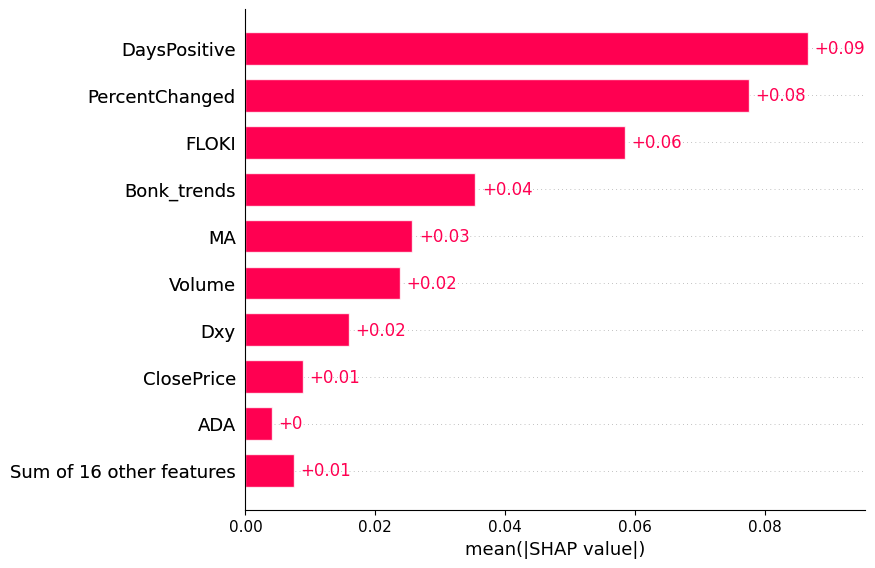

In [44]:
X_tr = df.loc[:"2025-01-01 00:00:00", :].drop(columns='Label')
y_tr = df.loc[:"2025-01-01 00:00:00", 'Label']

X = pd.DataFrame(X_tr, columns=X_tr.columns)

fit = SimpleImputer(strategy='mean')
X_tr = fit.fit_transform(X_tr)

dt =  DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_tr, y_tr)

explainer = shap.Explainer(dt, X)
shap_values = explainer(X)

shap.plots.bar(shap_values[:,:, 2])

DaysPositive, PercentChanged and Floki have the highest SHAP values among all features.